# **Modelo Original**

In [2]:
import pandas as pd
fraude_train = pd.read_csv("fraude_train.csv") 

In [4]:
import joblib

# Cargar modelos
knn_model = joblib.load("knn_model.pkl")
rf_model = joblib.load("rf_model.pkl")
xgb_model = joblib.load("xgb_model.pkl")


In [3]:
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split

# Separar variables
X = fraude_train.drop(columns=['isfraud'])
y = fraude_train['isfraud']

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Balanceo SOLO en entrenamiento
smote_tomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train, y_train)

In [5]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
import time

# === Definir modelos base (deben ser pipelines ya entrenados)
estimators = [
    ('knn', knn_model),
    ('rf', rf_model),
    ('xgb', xgb_model)
]


# === Meta-modelo: regresión logística regularizada
meta_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# === Crear el stacking classifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,            # validación interna para el meta-modelo
    passthrough=False,  # no pasar X además de predicciones
    n_jobs=-1
)

# === Validación cruzada externa + búsqueda de hiperparámetros del meta-modelo (C)
param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(roc_auc_score, needs_proba=True)

grid_search_stack = GridSearchCV(
    estimator=stacking_clf,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# === Entrenamiento con tiempo
start_time = time.time()
grid_search_stack.fit(X_train_bal, y_train_bal)
end_time = time.time()

print(f"\nTiempo total entrenamiento y búsqueda (Stacking): {end_time - start_time:.2f} segundos")
print("Mejor C:", grid_search_stack.best_params_['final_estimator__C'])
print("Mejor AUC promedio:", grid_search_stack.best_score_)


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\Asus\anaconda3\Lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Asus\anaconda3\Lib\site-packages\joblib\parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 136, in __call__
    retu


Tiempo total entrenamiento y búsqueda (Stacking): 1969.03 segundos
Mejor C: 0.01
Mejor AUC promedio: 0.9981442085534713


In [6]:
from sklearn.metrics import classification_report

# === Mejor modelo del GridSearchCV
best_stack_model = grid_search_stack.best_estimator_

# === Predicciones sobre el test original
y_pred_stack = best_stack_model.predict(X_test)
y_proba_stack = best_stack_model.predict_proba(X_test)[:, 1]

# === Reporte de clasificación
print("\n=== Classification Report - Stacking ===")
print(classification_report(y_test, y_pred_stack))



=== Classification Report - Stacking ===
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     39871
         1.0       0.80      0.68      0.73      3395

    accuracy                           0.96     43266
   macro avg       0.89      0.83      0.86     43266
weighted avg       0.96      0.96      0.96     43266



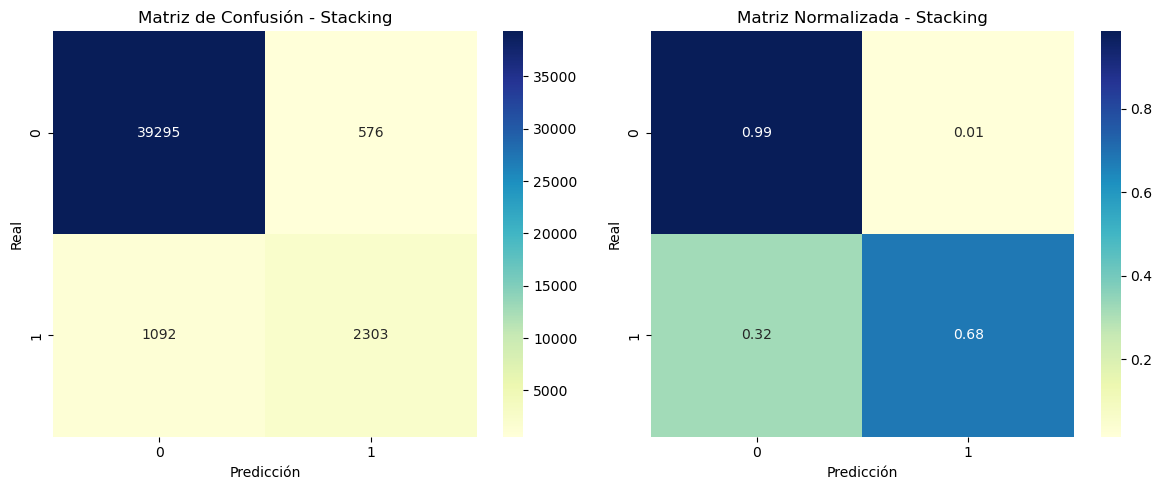

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Matrices
cm_stack = confusion_matrix(y_test, y_pred_stack)
cm_stack_norm = confusion_matrix(y_test, y_pred_stack, normalize='true')

# === Gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_stack, annot=True, fmt='d', cmap='YlGnBu', ax=axes[0])
axes[0].set_title("Matriz de Confusión - Stacking")
axes[0].set_xlabel("Predicción")
axes[0].set_ylabel("Real")

sns.heatmap(cm_stack_norm, annot=True, fmt='.2f', cmap='YlGnBu', ax=axes[1])
axes[1].set_title("Matriz Normalizada - Stacking")
axes[1].set_xlabel("Predicción")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.show()


AUC final sobre test (Stacking): 0.9370


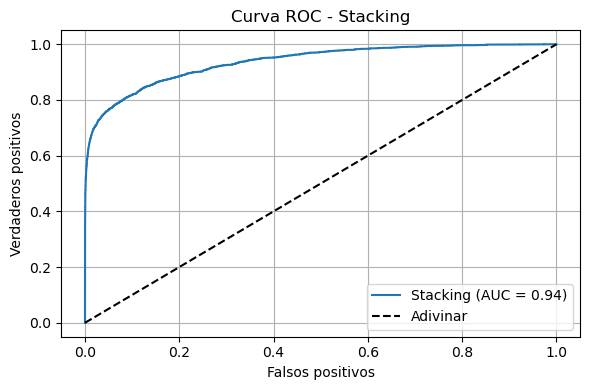

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score

# === Curva ROC
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_proba_stack)
auc_stack = roc_auc_score(y_test, y_proba_stack)
print(f"AUC final sobre test (Stacking): {auc_stack:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(fpr_stack, tpr_stack, label=f'Stacking (AUC = {auc_stack:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Adivinar')
plt.xlabel("Falsos positivos")
plt.ylabel("Verdaderos positivos")
plt.title("Curva ROC - Stacking")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
